# 1주차 심화 과제
- MNIST 데이터셋 다중 분류

- 구현 환경: 로컬 환경 rtx 4060 gpu만 사용하여 진행.

- python version: 3.9.21

- torch version: 2.2.1 

- 전체 코드 작동 시간: 30분 정도

- 기본 과제와의 차별점

    1) activation: Relu와 LeakyRelu, Sigmoid 비교
    2) optimizer: SGD, Adam 비교
    3) Dropout: 여부 비교

- 즉, 1번, 2번, 3번 조합을 비교하여 열 두번의 실험 세트를 시도하여 결과를 비교하고 모두 플로팅 해볼 예정입니다.

## [MY CODE] : HyperParameters

- 해당 노트 전체에서 사용되는 하이퍼 파라미터, 혹은 주요 변수를 모아두었습니다. 

In [1]:
import torch
import numpy as np
random_state = 42
device = "cuda" if torch.cuda.is_available else "cpu"
batch_size = 256
n_dim = 1024
lr = 1e-3
n_epochs = 50

## [MY CODE] Load Dataset

- 데이터셋을 로드하는 코드 cell 입니다. 

- train, val, test 데이터셋을 구성하여 훈련 중간 val로 점검을 하며 추후 테스트 데이터셋으로 마지막 metric을 찍어볼 예정입니다. 

- train 개수: 50000, val 개수: 8000, val 개수: 2000

- shape에서 채널이 3인 것을 확인했습니다. 따라서, 이에 따라 파라미터도 매우 많아질 것을 예상할 수 있습니다. 

- 그리고 transform은 추후에 dataset을 만들 때 사용할 예정입니다.

In [2]:
from sklearn.model_selection import train_test_split 
import torchvision

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
)

test_size= 0.2
x_train = trainset.data
y_train = trainset.targets
x_test = testset.data
y_test = testset.targets
x_val, x_test, y_val, y_test = train_test_split(
    x_test, 
    y_test, 
    test_size=test_size,
    random_state=random_state
)
# Check Dataset Shape
print(f"Train Dataset Shape:\nx_train:{x_train.shape}, y_train:{len(y_train)}", end="\n\n")
print(f"Val Dataset Shape:\nx_val:{x_val.shape}, y_val:{len(y_val)}", end="\n\n")
print(f"Test Dataset Shape:\nx_test:{x_test.shape}, y_test:{len(y_test)}", end="\n\n")

Files already downloaded and verified
Files already downloaded and verified
Train Dataset Shape:
x_train:(50000, 32, 32, 3), y_train:50000

Val Dataset Shape:
x_val:(8000, 32, 32, 3), y_val:8000

Test Dataset Shape:
x_test:(2000, 32, 32, 3), y_test:2000



## [MY CODE] Check Label Distribution

- train, val, test의 라벨 분포도 입니다.

- 치우친 데이터 없이 모두 고르게 되어 있습니다. 다중분류 상황에서 문제가 되는 라벨 불균형을 고려하지 않을 예정입니다.

- 라벨의 수는 0~9까지 10입니다. 따라서 다중 모델의 최종 layer의 차원 수는 10입니다. 

- train과 다르게 test와 val이 0.1로 딱 떨어지지 않는 것은 train_test_split을 했기 때문입니다. 

In [3]:
import pandas as pd
df = [
    pd.Series(label)
    .value_counts(normalize=True)
    .sort_index(ascending=True)
        for label in [y_train, y_val, y_test]
]
df = pd.concat(df, axis=1)
df.columns = ['train', 'val', 'test'] 
df

,train,val,test
0,0.1,0.101625,0.0935
1,0.1,0.101375,0.0945
2,0.1,0.099875,0.1005
3,0.1,0.100250,0.0990
4,0.1,0.102375,0.0905
5,0.1,0.101125,0.0955
6,0.1,0.098375,0.1065
7,0.1,0.096750,0.1130
8,0.1,0.099625,0.1015
9,0.1,0.098625,0.1055


## [MY CODE] Check Label Image

- train, val, test를 모두 검증하기 위하여 코드를 조금 수정하여 num을 입력하면 해당 샘플의 이미지와 라벨을 출력합니다.

- 채널이 3개이기 때문에 컬러 이미지가 출력됩니다.

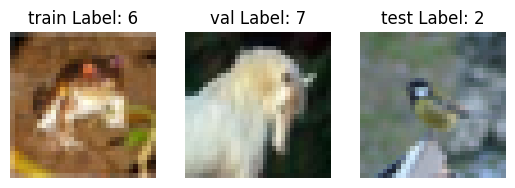

In [4]:
from matplotlib import pyplot as plt

def check_data(num, *args):
    for i, (sort, x, y) in enumerate(args):
        plt.subplot(1,len(args),i+1)
        plt.imshow(x[num], cmap='gray')
        plt.title(f"{sort} Label: {y[num]}")
        plt.axis('off')

# 몇 번째 샘플을 보여줄 것인지 결정하는 인자
num=0
check_data(
    num,
    ("train", x_train, y_train), 
    ("val", x_val, y_val), 
    ("test", x_test, y_test)
)

## [MY CODE] Make Torch Dataset

- torch dataset을 구성하여 dataloader에 올리는 것을 기반으로 하였습니다. 
- 또한 transform 과정에서 데이터 전처리에 해당하는 표준화를 수행하였습니다. 


## [FEEDBACK] 표준화 과정
- 공식문서에서 3채널의 평균과 표준편차를 모두 0.5로 하드코딩한 채로 진행하는 것을 권하였습니다.

- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

- 그런데 표준화를 한다는 것은 평균을 뺀 다음 표준편차로 나누는 것인데 어떻게 0.5, 0.5, 0.5가 나오는지 의문이 듭니다.

- 그래서 저는 직접 평균, 표준편차를 구해봤는데, 학습이 전혀 되지 않았습니다.

- 아래는 학습 로그를 캡처한 것입니다.

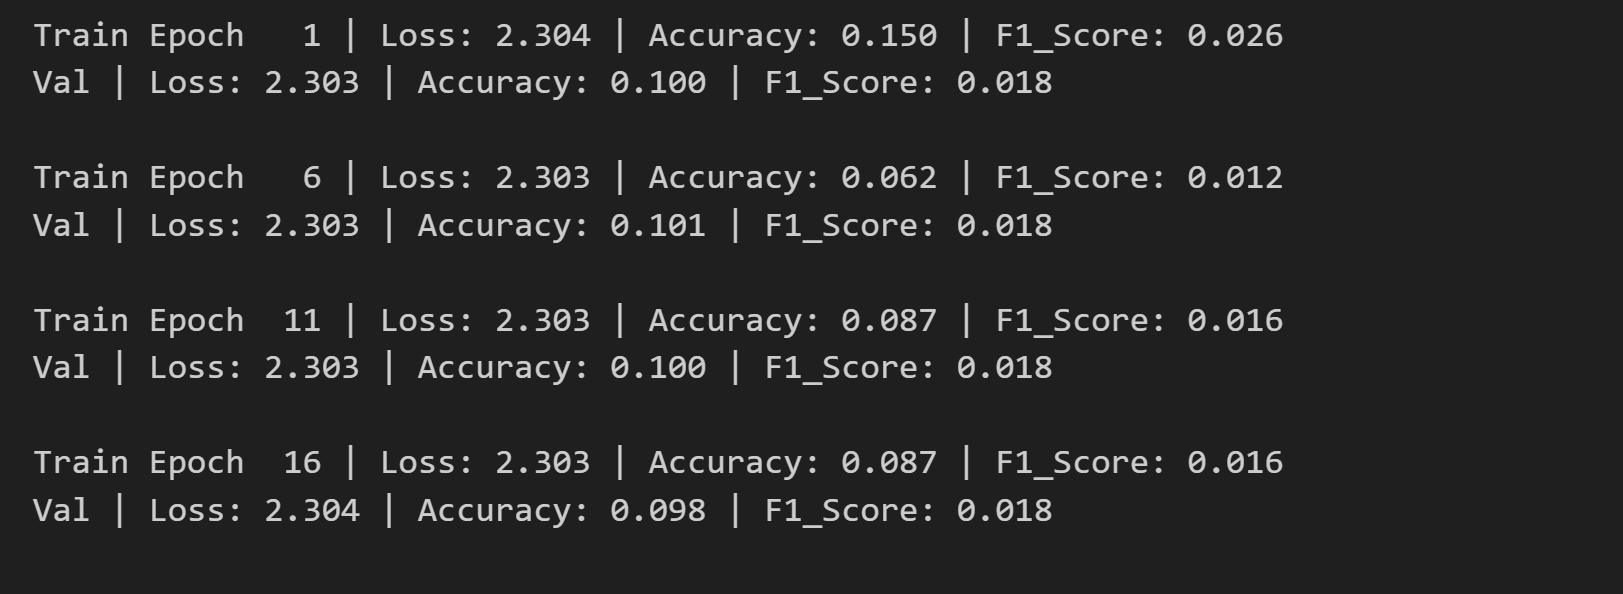


- 그래서 그냥 0.5로 평균 표준편차를 걸었습니다.

In [5]:
from torch.utils.data import Dataset
import numpy as np
import torchvision.transforms as transforms

class dastaset(Dataset):
    def __init__(self, x, y, transform=None):
        torch.manual_seed(random_state)
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]
        if self.transform:
            sample_x = self.transform(sample_x)
        return sample_x, sample_y
    
    def __len__(self):
        return len(self.x)
    
# 왜 각 채널의 평균과 표준편차를 0.5로 줘도 되는지 궁금합니다.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5,0.5,0.5), 
            (0.5,0.5,0.5), 
            )
    ],  
)

dataset_dict = {name:dastaset(x,y, transform)
                    for name,x,y in [
                            ('train', x_train, y_train),
                            ('val', x_val, y_val),
                            ('test', x_test, y_test)
                        ]
                }   
print(f"Dataset Keys: {dataset_dict.keys()}", end='\n\n')
for name in dataset_dict.keys():
    print(f"{name} len: {len(dataset_dict[name])}", end='\n\n')

Dataset Keys: dict_keys(['train', 'val', 'test'])

train len: 50000

val len: 8000

test len: 2000



## [MY CODE] Make Torch Dataloader

- train, val, test 데이터 가지고 모두 데이터 로더를 구성하였습니다.

- 코드를 간결하게 작성하기 위해 dict 형태로 묶었습니다.

- val, test는 shuffle을 하면 안된다는 조건이 있었으므로, shuffle_map이라는 dict을 사용해 지정하였습니다.

- 각각의 데이터로더가 잘 작동한는 것을 print를 통해 확인하였습니다.

In [6]:
from torch import nn
from itertools import product
input_dim = dataset_dict['train'][0][0].shape[0] * dataset_dict['train'][0][0].shape[1] * dataset_dict['train'][0][0].shape[2]

shuffle_map = {'train':True, 'val': False, 'test': False}

dataloader_dict = {name: torch.utils.data.DataLoader(
                            dataset_dict[name],
                            batch_size = batch_size,
                            shuffle=shuffle_map[name],
                        )
                        for name in dataset_dict.keys()
                    }

for name in dataloader_dict.keys():
    dataiter = iter(dataloader_dict[name])
    images, labels = next(dataiter)
    print(
        f"{name} input shape: {images.shape}",
        f"{name} output shape: {labels.shape}",
        f"{name} batch nums: {len(dataloader_dict[name])}",
        sep='\n',
        end='\n\n'
    )

train input shape: torch.Size([256, 3, 32, 32])
train output shape: torch.Size([256])
train batch nums: 196

val input shape: torch.Size([256, 3, 32, 32])
val output shape: torch.Size([256])
val batch nums: 32

test input shape: torch.Size([256, 3, 32, 32])
test output shape: torch.Size([256])
test batch nums: 8



## [MY CODE] Build Model

- 모델의 구조가 동적으로 변화하는 상황에서도 대응할 수 있도록 model config라는 dict을 따로 선언하였습니다.

- 내부에서는 hidden layers와 final layer를 구분하여 model summary가 더 가시적으로 보이도록 하였습니다. 

- 현재 다중 분류 클래스스 개수가 10개인데, 마지막 출력이 1로 되어있는 것이 이상하다고 생각하여 10으로 정정했습니다. 

- 다중분류 상황에서 loss 함수는 crossentropy를 사용하고 마지막 계층의 활성화 함수는 softmax여야 하지만, crossentropy 함수가 softmax를 계산 과정으로 품고 있기 때문에, 마지막 계층의 활성화함수는 꺼두었습니다.

- 참조: https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch

- 아래는 activation에 대하여 경우 3가지, dropout에 대하여 경우 2가지, optimizer에 대하여 경우 2가지해서 총 12가지의 경우의 수에 대하여 실험을 해보는 코드입니다.

- 모델을 config를 통하여 동적으로 실행합니다.


## [FEED BACK]

- dropout은 활성화함수 앞에 있어야 하나요?

- https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout#answer-40295999 

In [7]:
from itertools import product
activation_lst = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid()]
dropout_lst = [True, False]
optimizer_lst = ['Adam', 'SGD']

class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_layers = nn.ModuleDict() 
        for i, (name, (input_dim, output_dim, activation, flag)) in enumerate(config.items()):
            if i + 1 != len(config):
                self.hidden_layers[f"{name}_layer"] = nn.Linear(input_dim, output_dim)
                # flag가 True일 때에만 dropout이 삽입됩니다.
                # 이 때 dropout layer가 여기에 있는 게 맞나요?
                # 

                self.hidden_layers[f"{name}_activation"] = activation
                if flag:
                    self.hidden_layers[f"{name}_dropout"] = nn.Dropout(p=0.1)

        self.final_layer = nn.ModuleDict() 
        self.final_layer[f"{list(config.keys())[-1]}_layer"] = nn.Linear(list(config.values())[-1][0], list(config.values())[-1][1])

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for layer in self.hidden_layers.values():
            x = layer(x)
        for layer in self.final_layer.values():
            x = layer(x)
        return x

## [MY CODE] Start Train

- train과 val 데이터로더를 통해 훈련을 하고 있습니다.

- 특징1: loss를 계산할 때 배치당 loss로 평균을 내어서, validation 과정에서 도출 된 loss와 같은 기준선에서 비교가 가능하도록 scaling을 하였습니다.

- 특징2: validation을 매 epoch이 아니라 5 epoch 마다 하여서, 추세를 확인하는 용도로 사용하였습니다.

- 특징3: 다중분류이므로 accuracy와 f1_score를 같이 가져왔습니다. 이 때 sklearn 라이브러리를 활용하여 custom 구현에 의한 오류 발생 여지를 줄였습니다.

## [FEEDBACK]

- onehot encoding을 다중 분류 과정에서 해야 한다고 알고 있습니다.

- 그러나 CrossEntropy는 정수 인코딩된 클래스를 요구받는다고 합니다.

- onehot encoding을 안한 것이 metric을 저하시키진 않는지 궁금합니다.

## [LOG] Train, Val Metric

- 훈련 과정에서 5 epoch 마다의 metric을 모두 찍고 있습니다.

- 12가지의 케이스에 대하여 모두 로그를 남깁니다. 

In [8]:
from torch.optim import SGD, Adam
from sklearn.metrics import accuracy_score, f1_score

result_dict = {}
for i, (activation, dropout, optimizer_name) in enumerate(product(activation_lst, dropout_lst, optimizer_lst)):
  print(f"{i+1}/{len(list(product(activation_lst, dropout_lst, optimizer_lst)))} Case",
        f"활성화 함수: {activation}, Dropout 여부: {dropout}, optimizer: {optimizer_name}", sep='\n')
  
  model_config = {
      "layer1":(input_dim, n_dim, activation, dropout),
      "layer2":(n_dim, n_dim, activation, dropout),
      "final":(n_dim, 10, None, None)
  }

  model = Model(model_config)
  model = model.to(device)
  print(model)

  optimizer_dict = {
      'Adam': Adam(model.parameters(), lr=lr),
      'SGD': SGD(model.parameters(), lr=lr)
      }
  optimizer = optimizer_dict[optimizer_name]
  criterion = nn.CrossEntropyLoss()

  train_metric_dict = {'loss':[],'accuracy':[],'f1_score':[]}
  val_metric_dict = {'loss':[],'accuracy':[],'f1_score':[]}

  print('훈련 시작...')
  for epoch in range(n_epochs):
    total_loss_lst = []
    total_preds_lst=[]
    total_labels_lst=[]

    for inputs, labels in dataloader_dict['train']:
      model.train()
      model.zero_grad()
      inputs, labels = inputs.to(device), labels.to(device).long() 
      preds = model(inputs)
      loss = criterion(preds, labels)

      preds_labels = torch.max(preds, dim=1).indices.detach().cpu().numpy()
      total_preds_lst.extend(preds_labels)
      labels = labels.detach().cpu().numpy()
      total_labels_lst.extend(labels)

      loss.backward()
      optimizer.step()
      total_loss_lst.append(loss.item())
      
    accuracy = accuracy_score(preds_labels, labels)
    f1 = f1_score(preds_labels, labels, average='macro')
    total_loss = np.mean(total_loss_lst)
    
    train_metric_dict['loss'].append(total_loss)
    train_metric_dict['accuracy'].append(accuracy)
    train_metric_dict['f1_score'].append(f1)

    if (epoch+1) % 5 == 1:
      print(f"Train Epoch {epoch+1:3d} | Loss: {total_loss:.3f} | Accuracy: {accuracy:.3f} | F1_Score: {f1:.3f}")
      val_loss_lst = []
      val_preds_lst=[]
      val_labels_lst=[]

      for inputs, labels in dataloader_dict['val']:
        model.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device).long() 

        with torch.no_grad():
          model.eval()
          preds = model(inputs)

        loss = criterion(preds, labels)
        preds_labels = torch.max(preds, dim=1).indices.detach().cpu().numpy()
        val_preds_lst.extend(preds_labels)
        labels = labels.detach().cpu().numpy()
        val_labels_lst.extend(labels)
        val_loss_lst.append(loss.item())
        
      accuracy = accuracy_score(val_preds_lst, val_labels_lst)
      f1 = f1_score(val_preds_lst, val_labels_lst, average='macro')
      val_loss = np.mean(val_loss_lst)

      val_metric_dict['loss'].append((epoch,val_loss))
      val_metric_dict['accuracy'].append((epoch,accuracy))
      val_metric_dict['f1_score'].append((epoch,f1))
      
      print(f"Val | Loss: {val_loss:.3f} | Accuracy: {accuracy:.3f} | F1_Score: {f1:.3f}", end='\n\n')
  result_dict[(activation, dropout, optimizer_name)] = {'train':train_metric_dict, 'val':val_metric_dict, 'model': model}
  print("-"*15,"\n")

1/12 Case
활성화 함수: ReLU(), Dropout 여부: True, optimizer: Adam
Model(
  (hidden_layers): ModuleDict(
    (layer1_layer): Linear(in_features=3072, out_features=1024, bias=True)
    (layer1_dropout): Dropout(p=0.1, inplace=False)
    (layer1_activation): ReLU()
    (layer2_layer): Linear(in_features=1024, out_features=1024, bias=True)
    (layer2_dropout): Dropout(p=0.1, inplace=False)
    (layer2_activation): ReLU()
  )
  (final_layer): ModuleDict(
    (final_layer): Linear(in_features=1024, out_features=10, bias=True)
  )
)
훈련 시작...
Train Epoch   1 | Loss: 1.647 | Accuracy: 0.487 | F1_Score: 0.460
Val | Loss: 1.484 | Accuracy: 0.472 | F1_Score: 0.473

Train Epoch   6 | Loss: 1.071 | Accuracy: 0.637 | F1_Score: 0.589
Val | Loss: 1.329 | Accuracy: 0.547 | F1_Score: 0.545

Train Epoch  11 | Loss: 0.711 | Accuracy: 0.662 | F1_Score: 0.638
Val | Loss: 1.499 | Accuracy: 0.551 | F1_Score: 0.551

Train Epoch  16 | Loss: 0.474 | Accuracy: 0.713 | F1_Score: 0.705
Val | Loss: 1.772 | Accuracy: 0.551

## [MY CODE] Case Plotting

각 케이스에 대하여 모두 플로팅을 하여봅니다.

- 결론1: Adam이 SGD보다 월등히 성능이 좋았습니다.

- 결론2: Relu와 LeakyRelu가 Sigmoid보다 월등히 성능이 좋습니다.

- 결론3: Dropout을 켠 것이 끈 것보다 전체적으로 약간 성능이 좋았습니다.

- 결론4: 전반적으로 Adam optimizer로, Relu나 LeakyRelu 활성화 함수를 사용하고 Dropout을 True로 줬을 때 성능이 좋았습니다. 

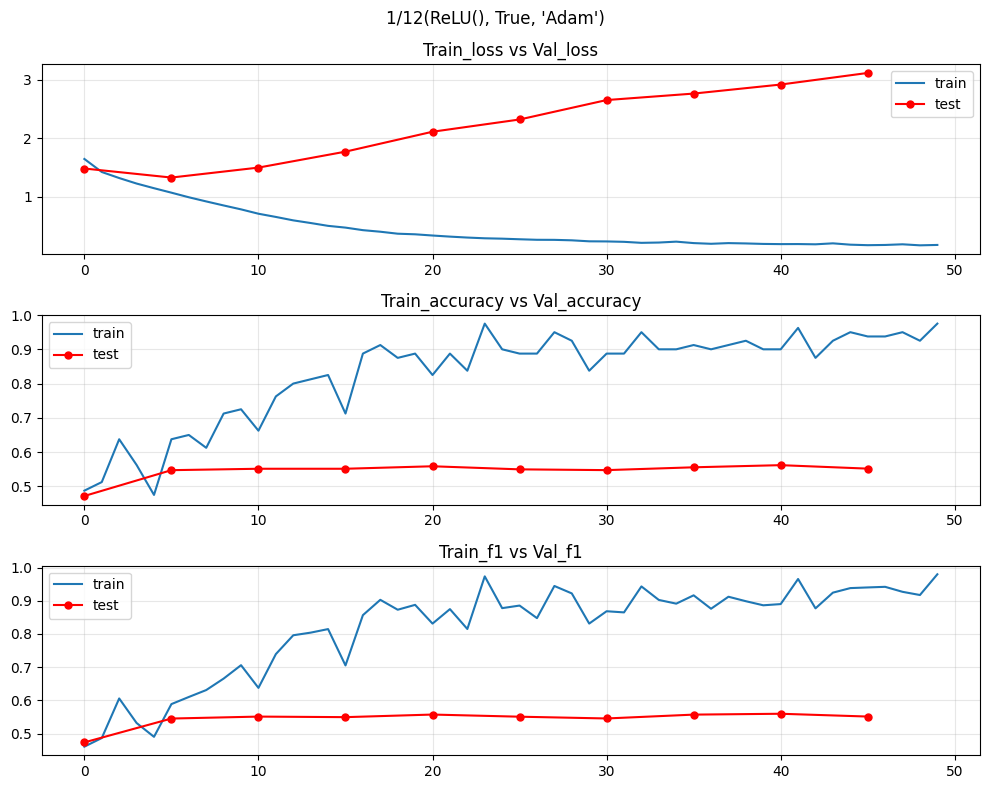

---------------


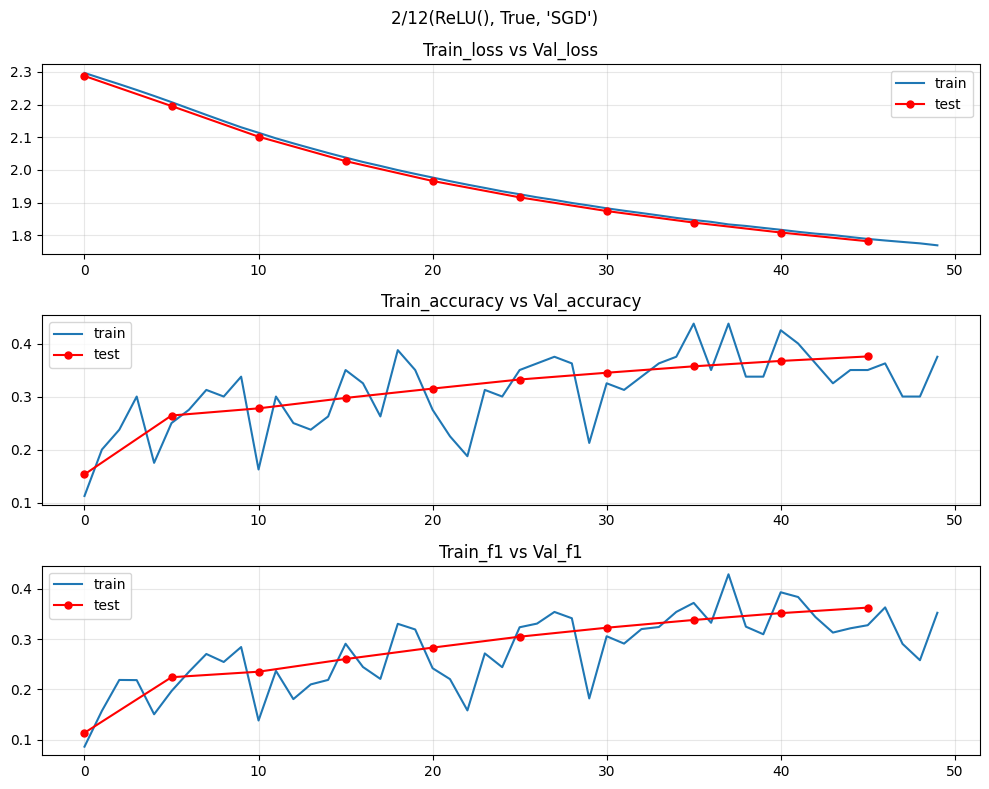

---------------


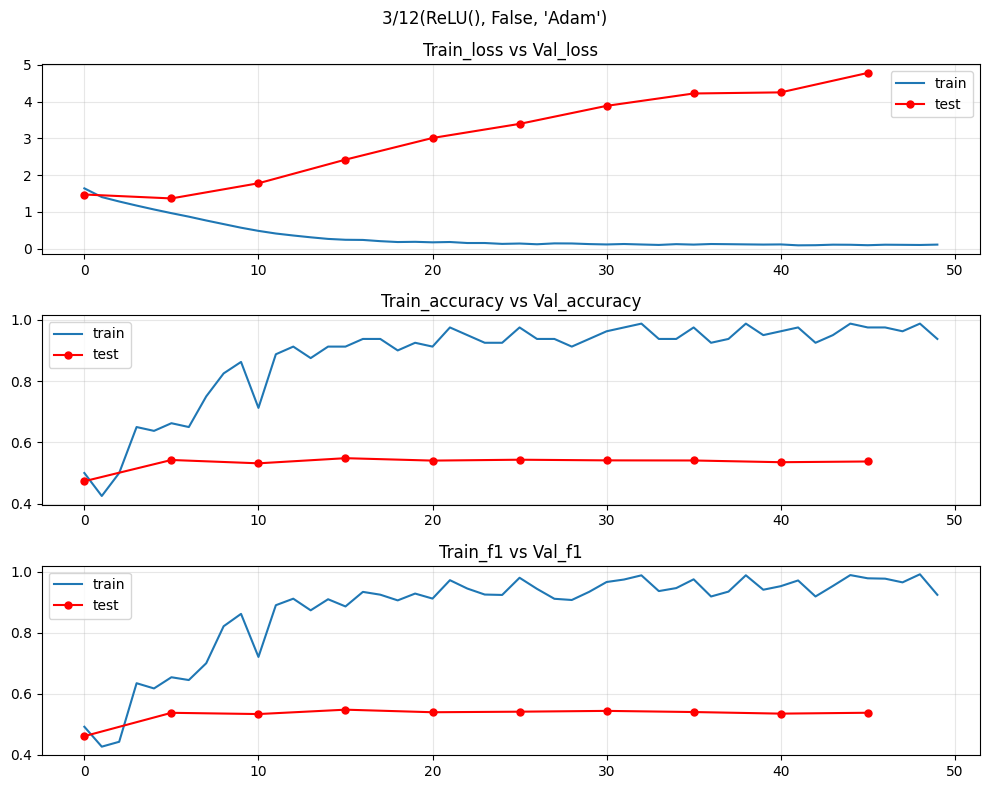

---------------


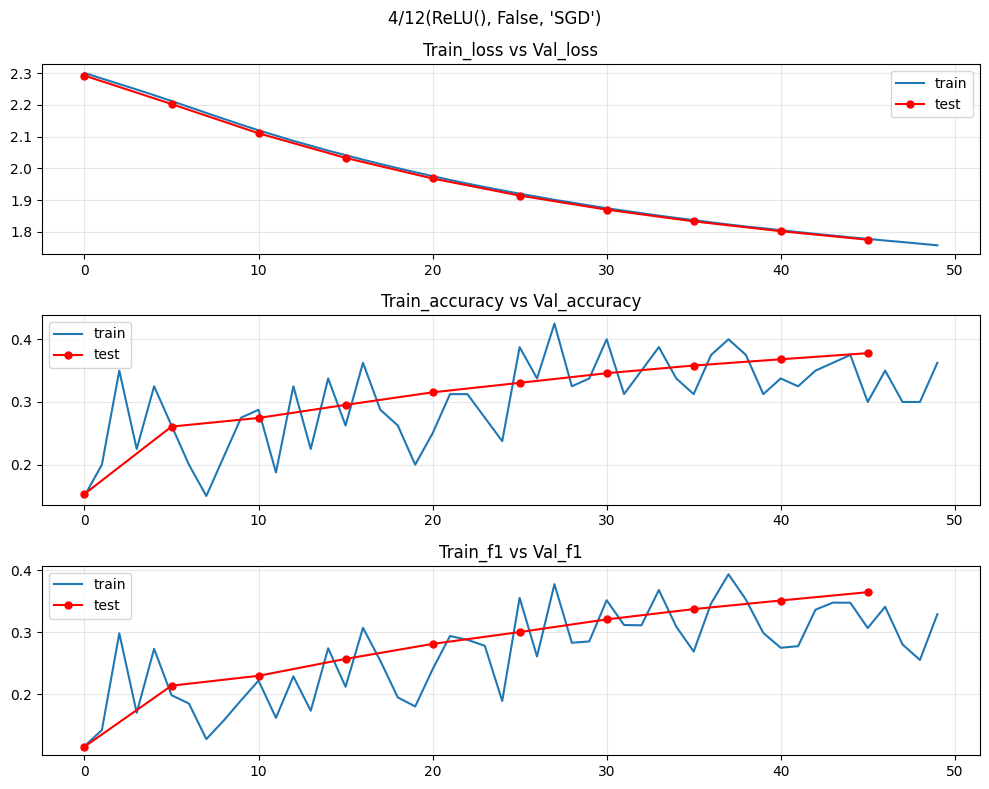

---------------


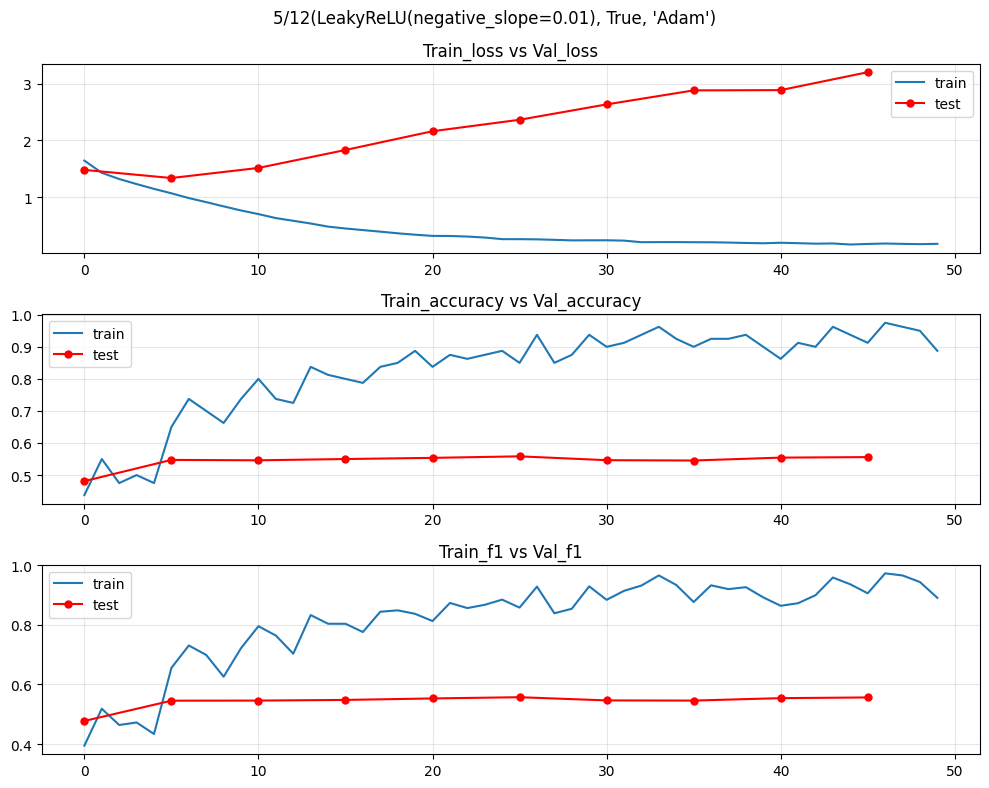

---------------


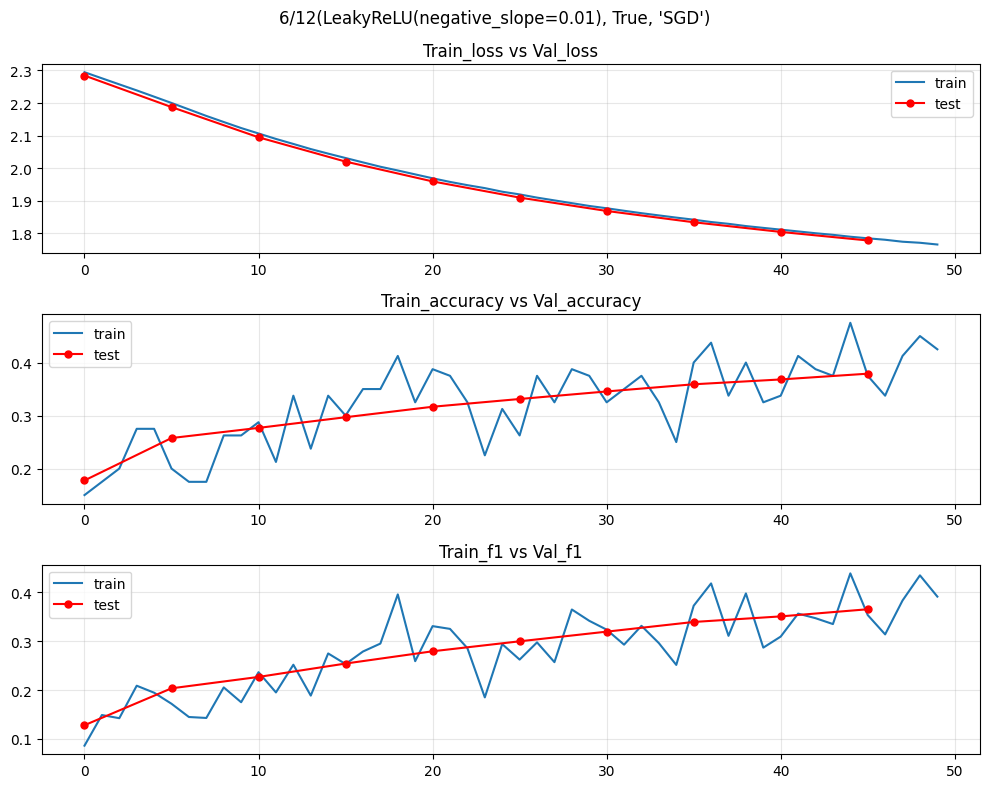

---------------


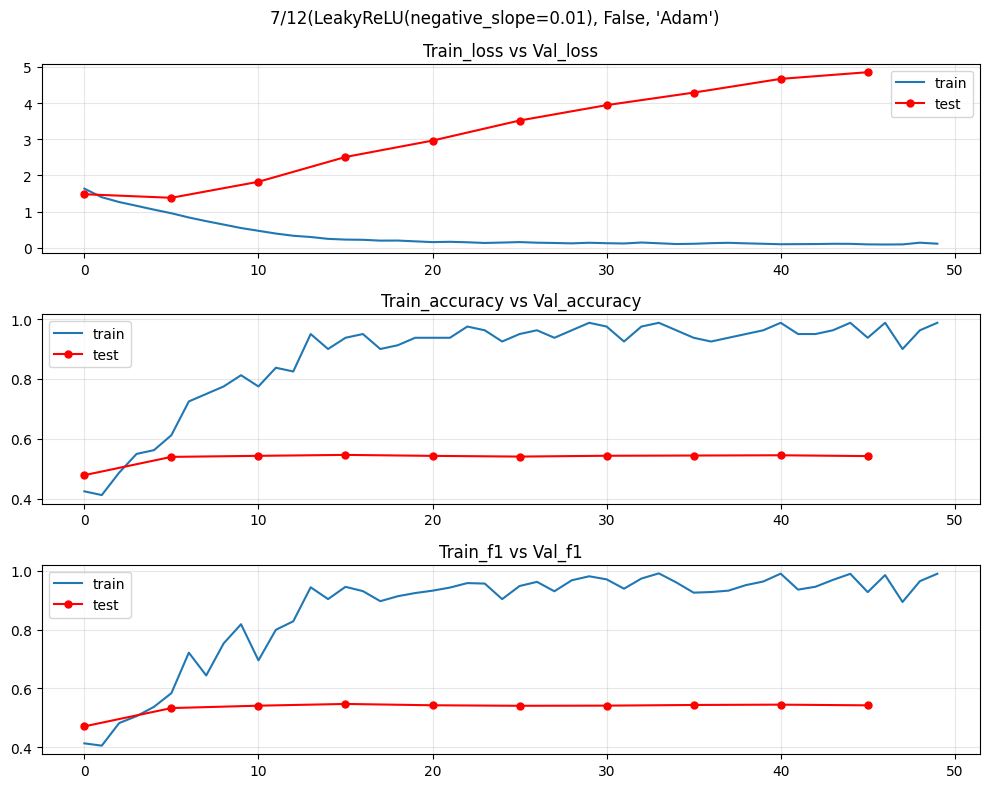

---------------


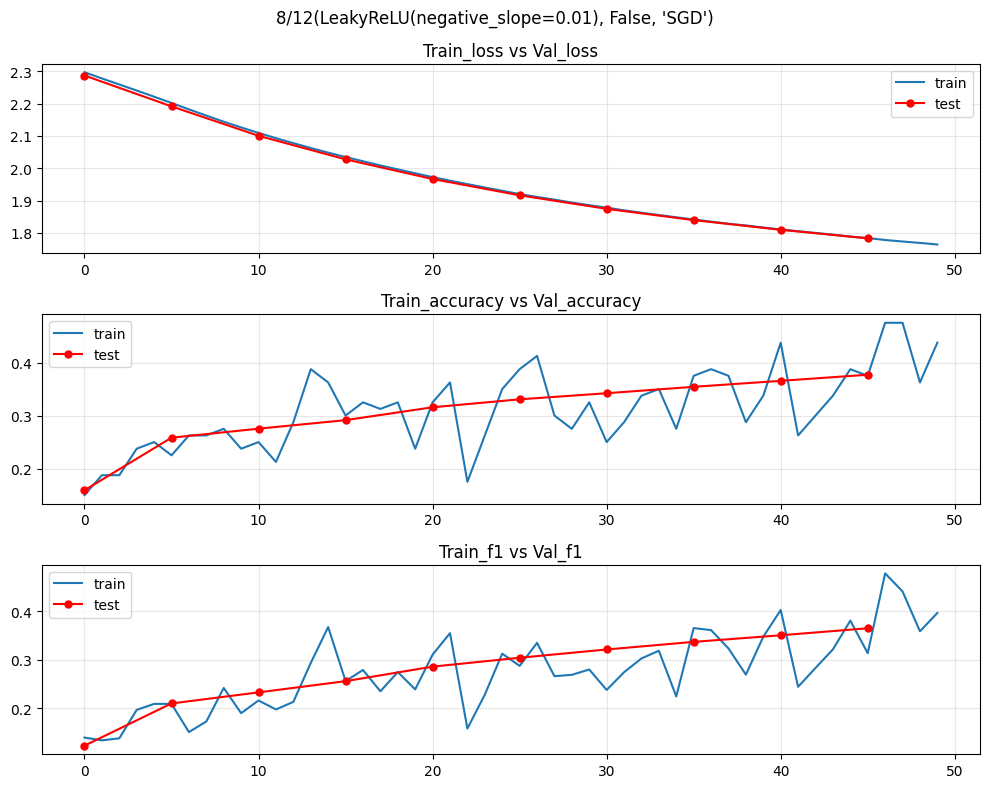

---------------


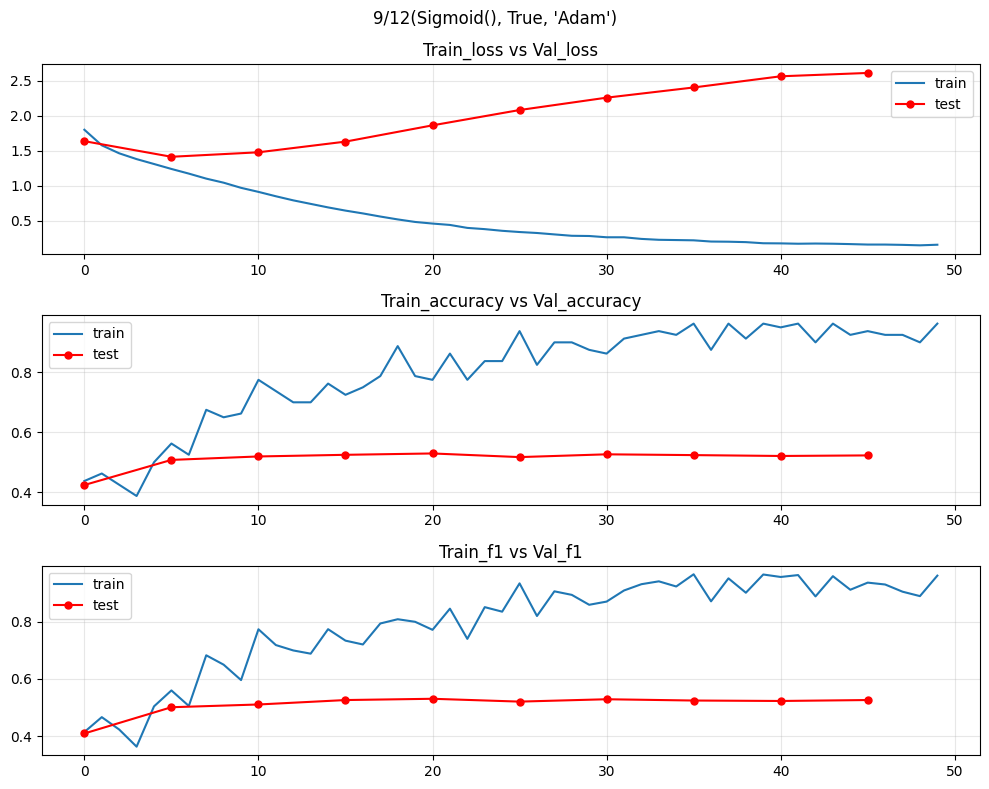

---------------


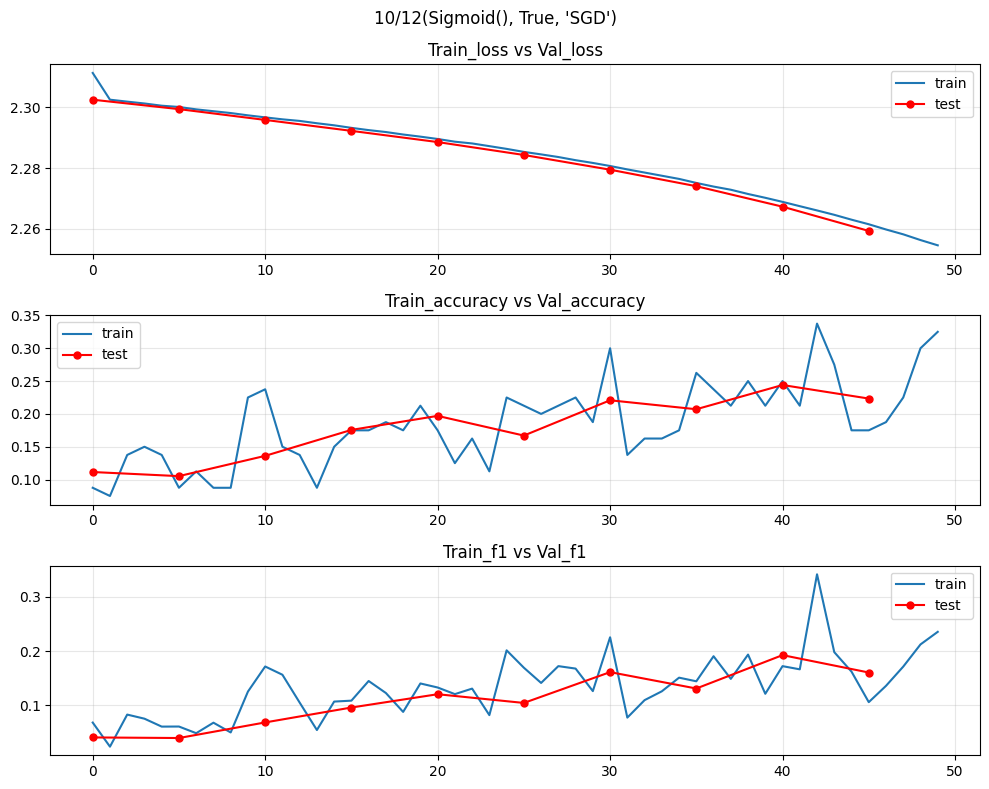

---------------


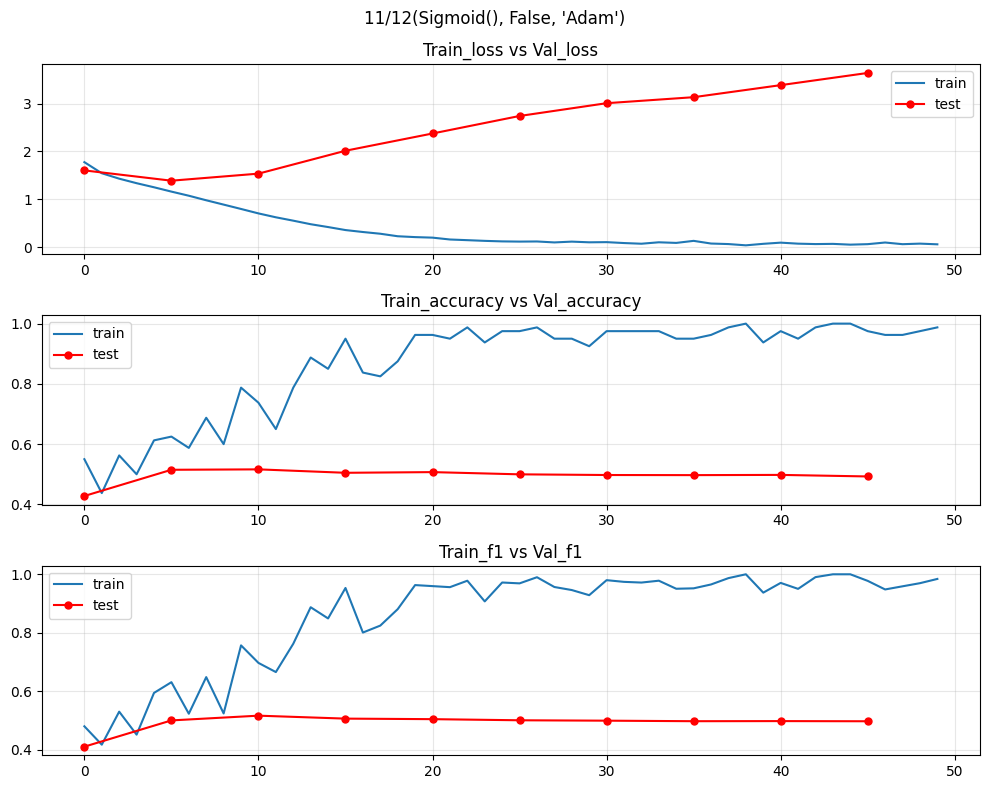

---------------


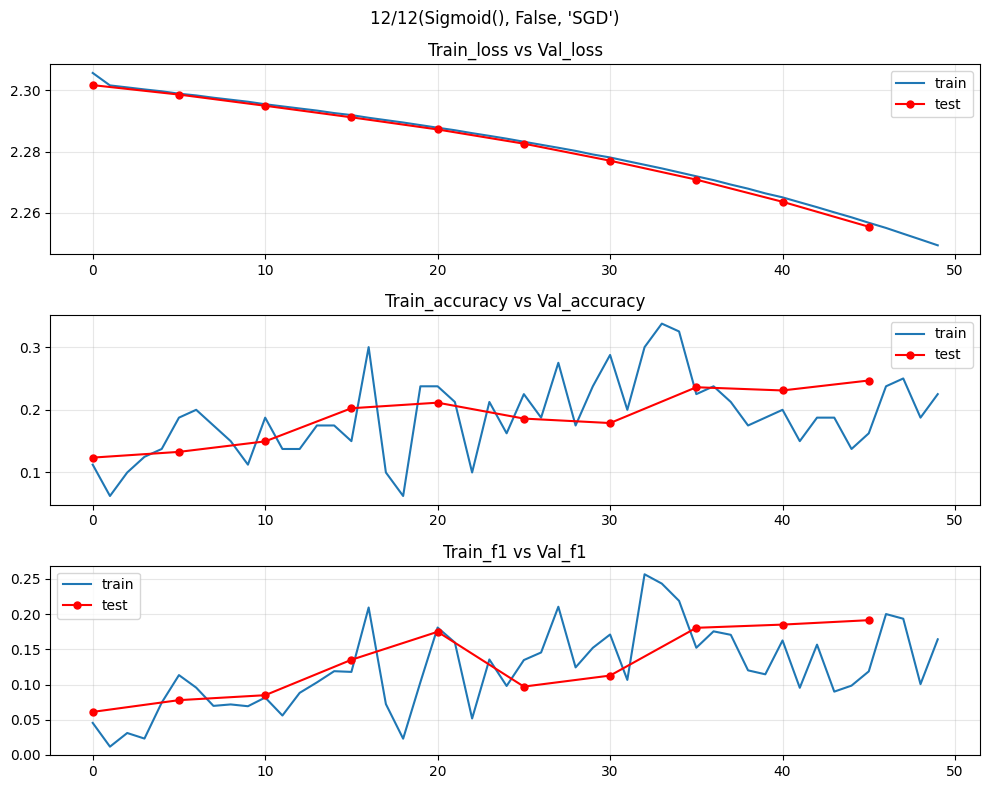

---------------


In [17]:
for i,(name, train_val_dict) in enumerate(result_dict.items()):
    train_metric_dict = train_val_dict['train']
    val_metric_dict = train_val_dict['val']
    
    plt.figure(figsize=(10,8))
    plt.subplot(3,1,1)
    plt.plot(range(len(train_metric_dict['loss'])), train_metric_dict['loss'], label='train')

    x = [point[0] for point in val_metric_dict['loss']]
    y = [point[1] for point in val_metric_dict['loss']]

    plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='red', label='test')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title("Train_loss vs Val_loss")

    plt.subplot(3,1,2)
    plt.plot(range(len(train_metric_dict['accuracy'])), train_metric_dict['accuracy'], label='train')

    x = [point[0] for point in val_metric_dict['accuracy']]
    y = [point[1] for point in val_metric_dict['accuracy']]

    plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='red', label='test')  # s는 점의 크기
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title("Train_accuracy vs Val_accuracy")

    plt.subplot(3,1,3)
    plt.plot(range(len(train_metric_dict['f1_score'])), train_metric_dict['f1_score'], label='train')

    x = [point[0] for point in val_metric_dict['f1_score']]
    y = [point[1] for point in val_metric_dict['f1_score']]

    plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='red', label='test')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title("Train_f1 vs Val_f1")
    plt.suptitle(f"{i+1}/{len(result_dict)}{name}")
    plt.tight_layout()
    plt.show()
    print("-"* 15)

## [MY CODE] Test Metric

- test 데이터셋을 가지고 최종 metric을 찍어보았습니다.

- val dataset과 비슷한 metric이 나온 것을 보니 훈련이 잘 된 것으로 판단이 되었습니다. 

## [LOG] Test Metric

In [18]:
test_dict = {}
for i,(name, train_val_dict) in enumerate(result_dict.items()):
  print(f"{i+1}/{len(result_dict)} Test Metric")
  model = train_val_dict['model']
  test_loss_lst = []
  test_preds_lst=[]
  test_labels_lst=[]
  for inputs, labels in dataloader_dict['test']:
      model.zero_grad()
      inputs, labels = inputs.to(device), labels.to(device).long() 
      with torch.no_grad():
          model.eval()
          preds = model(inputs)
      loss = criterion(preds, labels)
      preds_labels = torch.max(preds, dim=1).indices.detach().cpu().numpy()
      test_preds_lst.extend(preds_labels)
      labels = labels.detach().cpu().numpy()
      test_labels_lst.extend(labels)
      test_loss_lst.append(loss.item())
  accuracy = accuracy_score(test_preds_lst, test_labels_lst)
  f1 = f1_score(test_preds_lst, test_labels_lst, average='macro')
  test_loss = np.mean(test_loss_lst)

  print(f"Test | Loss: {test_loss:.3f} | Accuracy: {accuracy:.3f} | F1_Score: {f1:.3f}", end='\n\n')
  print("-"*15)
  test_dict[name] = {'loss': test_loss, 'accuracy': accuracy, 'f1_score': f1}

1/12 Test Metric
Test | Loss: 3.167 | Accuracy: 0.562 | F1_Score: 0.562

---------------
2/12 Test Metric
Test | Loss: 1.748 | Accuracy: 0.393 | F1_Score: 0.382

---------------
3/12 Test Metric
Test | Loss: 4.972 | Accuracy: 0.520 | F1_Score: 0.519

---------------
4/12 Test Metric
Test | Loss: 1.741 | Accuracy: 0.394 | F1_Score: 0.382

---------------
5/12 Test Metric
Test | Loss: 3.158 | Accuracy: 0.558 | F1_Score: 0.557

---------------
6/12 Test Metric
Test | Loss: 1.744 | Accuracy: 0.388 | F1_Score: 0.375

---------------
7/12 Test Metric
Test | Loss: 4.745 | Accuracy: 0.567 | F1_Score: 0.565

---------------
8/12 Test Metric
Test | Loss: 1.748 | Accuracy: 0.386 | F1_Score: 0.376

---------------
9/12 Test Metric
Test | Loss: 2.726 | Accuracy: 0.529 | F1_Score: 0.530

---------------
10/12 Test Metric
Test | Loss: 2.250 | Accuracy: 0.219 | F1_Score: 0.155

---------------
11/12 Test Metric
Test | Loss: 3.549 | Accuracy: 0.497 | F1_Score: 0.498

---------------
12/12 Test Metric
T

In [19]:
index_lst = []
metric_lst = []
for name, value in test_dict.items():
    index_lst.append(name)
    metric_lst.append(value)
test_df = pd.DataFrame(metric_lst)
test_df.index = index_lst
test_df['case'] = test_df.index
test_df.index = range(len(test_df))
test_df

,loss,accuracy,f1_score,case
0,3.166706,0.5620,0.562101,"(ReLU(), True, Adam)"
1,1.747619,0.3930,0.381869,"(ReLU(), True, SGD)"
2,4.972142,0.5200,0.519208,"(ReLU(), False, Adam)"
3,1.741302,0.3940,0.381792,"(ReLU(), False, SGD)"
4,3.158050,0.5580,0.557151,"(LeakyReLU(negative_slope=0.01), True, Adam)"
5,1.743732,0.3875,0.375111,"(LeakyReLU(negative_slope=0.01), True, SGD)"
6,4.745032,0.5670,0.565183,"(LeakyReLU(negative_slope=0.01), False, Adam)"
7,1.748394,0.3860,0.375598,"(LeakyReLU(negative_slope=0.01), False, SGD)"
8,2.726417,0.5295,0.530446,"(Sigmoid(), True, Adam)"
9,2.250333,0.2190,0.154748,"(Sigmoid(), True, SGD)"


In [23]:
test_df.iloc[test_df['loss'].sort_values().index]

,loss,accuracy,f1_score,case
3,1.741302,0.3940,0.381792,"(ReLU(), False, SGD)"
5,1.743732,0.3875,0.375111,"(LeakyReLU(negative_slope=0.01), True, SGD)"
1,1.747619,0.3930,0.381869,"(ReLU(), True, SGD)"
7,1.748394,0.3860,0.375598,"(LeakyReLU(negative_slope=0.01), False, SGD)"
11,2.244860,0.2160,0.144136,"(Sigmoid(), False, SGD)"
9,2.250333,0.2190,0.154748,"(Sigmoid(), True, SGD)"
8,2.726417,0.5295,0.530446,"(Sigmoid(), True, Adam)"
4,3.158050,0.5580,0.557151,"(LeakyReLU(negative_slope=0.01), True, Adam)"
0,3.166706,0.5620,0.562101,"(ReLU(), True, Adam)"
10,3.548521,0.4970,0.498254,"(Sigmoid(), False, Adam)"


In [25]:
test_df.iloc[test_df['accuracy'].sort_values(ascending=False).index]

,loss,accuracy,f1_score,case
6,4.745032,0.5670,0.565183,"(LeakyReLU(negative_slope=0.01), False, Adam)"
0,3.166706,0.5620,0.562101,"(ReLU(), True, Adam)"
4,3.158050,0.5580,0.557151,"(LeakyReLU(negative_slope=0.01), True, Adam)"
8,2.726417,0.5295,0.530446,"(Sigmoid(), True, Adam)"
2,4.972142,0.5200,0.519208,"(ReLU(), False, Adam)"
10,3.548521,0.4970,0.498254,"(Sigmoid(), False, Adam)"
3,1.741302,0.3940,0.381792,"(ReLU(), False, SGD)"
1,1.747619,0.3930,0.381869,"(ReLU(), True, SGD)"
5,1.743732,0.3875,0.375111,"(LeakyReLU(negative_slope=0.01), True, SGD)"
7,1.748394,0.3860,0.375598,"(LeakyReLU(negative_slope=0.01), False, SGD)"


In [26]:
test_df.iloc[test_df['f1_score'].sort_values(ascending=False).index]

,loss,accuracy,f1_score,case
6,4.745032,0.5670,0.565183,"(LeakyReLU(negative_slope=0.01), False, Adam)"
0,3.166706,0.5620,0.562101,"(ReLU(), True, Adam)"
4,3.158050,0.5580,0.557151,"(LeakyReLU(negative_slope=0.01), True, Adam)"
8,2.726417,0.5295,0.530446,"(Sigmoid(), True, Adam)"
2,4.972142,0.5200,0.519208,"(ReLU(), False, Adam)"
10,3.548521,0.4970,0.498254,"(Sigmoid(), False, Adam)"
1,1.747619,0.3930,0.381869,"(ReLU(), True, SGD)"
3,1.741302,0.3940,0.381792,"(ReLU(), False, SGD)"
7,1.748394,0.3860,0.375598,"(LeakyReLU(negative_slope=0.01), False, SGD)"
5,1.743732,0.3875,0.375111,"(LeakyReLU(negative_slope=0.01), True, SGD)"


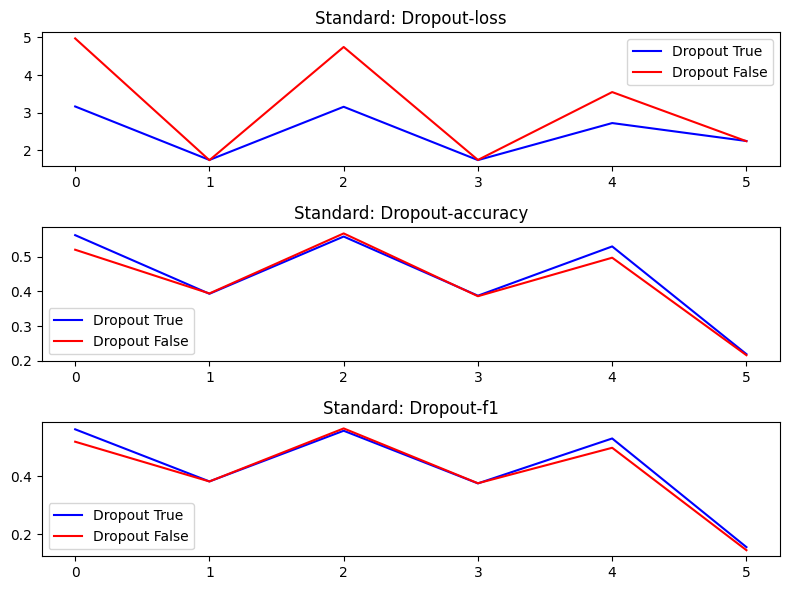

In [27]:
keyword = "True"
df_a = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

keyword = "False"
df_b = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

plt.figure(figsize=(8,6))

plt.subplot(3,1,1)
plt.plot(df_a['loss'], label = "Dropout True", color='blue')
plt.plot(df_b['loss'], label = "Dropout False", color='red')
plt.title(f"Standard: Dropout-loss")
plt.legend()

plt.subplot(3,1,2)
plt.plot(df_a['accuracy'], label = "Dropout True", color='blue')
plt.plot(df_b['accuracy'], label = "Dropout False", color='red')
plt.title(f"Standard: Dropout-accuracy")
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_a['f1_score'], label = "Dropout True", color='blue')
plt.plot(df_b['f1_score'], label = "Dropout False", color='red')
plt.title(f"Standard: Dropout-f1")
plt.legend()

plt.tight_layout()
plt.show()


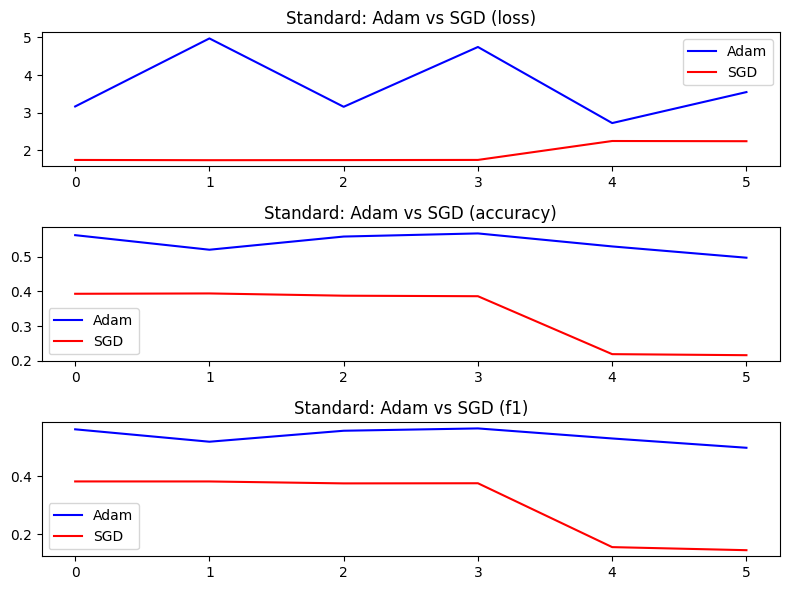

In [28]:
keyword = "Adam"
df_a = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

keyword = "SGD"
df_b = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

plt.figure(figsize=(8,6))

plt.subplot(3,1,1)
plt.plot(df_a['loss'], label = "Adam", color='blue')
plt.plot(df_b['loss'], label = "SGD", color='red')
plt.title(f"Standard: Adam vs SGD (loss)")
plt.legend()

plt.subplot(3,1,2)
plt.plot(df_a['accuracy'], label = "Adam", color='blue')
plt.plot(df_b['accuracy'], label = "SGD", color='red')
plt.title(f"Standard: Adam vs SGD (accuracy)")
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_a['f1_score'], label = "Adam", color='blue')
plt.plot(df_b['f1_score'], label = "SGD", color='red')
plt.title(f"Standard: Adam vs SGD (f1)")
plt.legend()

plt.tight_layout()
plt.show()


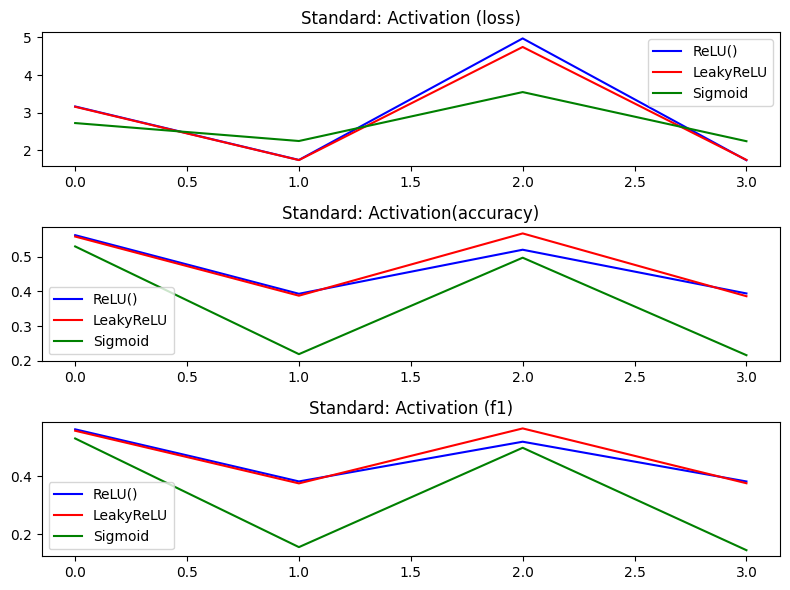

In [29]:
keyword = "ReLU()"
df_a = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

keyword = "LeakyReLU"
df_b = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

keyword = "Sigmoid"
df_c = test_df[test_df['case'].apply(lambda x: True if keyword in str(x) else False)].reset_index(drop=True)

plt.figure(figsize=(8,6))

plt.subplot(3,1,1)
plt.plot(df_a['loss'], label = "ReLU()", color='blue')
plt.plot(df_b['loss'], label = "LeakyReLU", color='red')
plt.plot(df_c['loss'], label = "Sigmoid", color='green')
plt.title(f"Standard: Activation (loss)")
plt.legend()

plt.subplot(3,1,2)
plt.plot(df_a['accuracy'], label = "ReLU()", color='blue')
plt.plot(df_b['accuracy'], label = "LeakyReLU", color='red')
plt.plot(df_c['accuracy'], label = "Sigmoid", color='green')
plt.title(f"Standard: Activation(accuracy)")
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_a['f1_score'], label = "ReLU()", color='blue')
plt.plot(df_b['f1_score'], label = "LeakyReLU", color='red')
plt.plot(df_c['f1_score'], label = "Sigmoid", color='green')
plt.title(f"Standard: Activation (f1)")
plt.legend()

plt.tight_layout()
plt.show()
